In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from joblib import dump
import sklearn, pandas, numpy

print("sklearn:", sklearn.__version__)
print("pandas:", pandas.__version__)
print("numpy:", numpy.__version__)

sklearn: 1.3.2
pandas: 2.1.4
numpy: 1.26.4


In [88]:
df = pd.read_csv('Flight_Tickets.csv')
df.head()

,AIRLINE,SOURCE CITY,STOPS,DESTINATION CITY,PRICE CLASS,BOOKING YEAR,BOOKING MONTH,BOOKING DAY,DAYS LEFT,FLIGHT YEAR,FLIGHT MONTH,FLIGHT DAY,DEPARTURE TIME,DURATION,ARRIVAL TIME,PRICE,CGST,SGST,NEW PRICE
0,SpiceJet,Delhi,Zero,Mumbai,Economy,2025,11,8,1,2025,11,9,Early Morning,2.17,Morning,5953,535.77,535.77,7024.54
1,SpiceJet,Delhi,Zero,Mumbai,Economy,2024,1,6,1,2024,1,7,Evening,2.33,Night,5953,535.77,535.77,7024.54
2,AirAsia,Delhi,Zero,Mumbai,Economy,2025,10,26,1,2025,10,27,Afternoon,2.17,Afternoon,5956,536.04,536.04,7028.08
3,Vistara,Delhi,Zero,Mumbai,Economy,2024,10,2,1,2024,10,3,Morning,2.25,Morning,5955,535.95,535.95,7026.90
4,Vistara,Delhi,Zero,Mumbai,Economy,2024,11,13,1,2024,11,14,Early Morning,2.33,Morning,5955,535.95,535.95,7026.90


In [89]:
df.shape

(297921, 19)

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297921 entries, 0 to 297920
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   AIRLINE           297921 non-null  object 
 1   SOURCE CITY       297921 non-null  object 
 2   STOPS             297921 non-null  object 
 3   DESTINATION CITY  297921 non-null  object 
 4   PRICE CLASS       297921 non-null  object 
 5   BOOKING YEAR      297921 non-null  int64  
 6   BOOKING MONTH     297921 non-null  int64  
 7   BOOKING DAY       297921 non-null  int64  
 8   DAYS LEFT         297921 non-null  int64  
 9   FLIGHT YEAR       297921 non-null  int64  
 10  FLIGHT MONTH      297921 non-null  int64  
 11  FLIGHT DAY        297921 non-null  int64  
 12  DEPARTURE TIME    297921 non-null  object 
 13  DURATION          297921 non-null  float64
 14  ARRIVAL TIME      297921 non-null  object 
 15  PRICE             297921 non-null  int64  
 16  CGST              29

In [91]:
df.drop_duplicates(inplace=True)    

In [92]:
Q1 = df['PRICE'].quantile(0.25)
Q3 = df['PRICE'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_bound, upper_bound

(-51889.0, 99167.0)

In [93]:
df = df[
    (df['PRICE'] >= lower_bound) &
    (df['PRICE'] <= upper_bound)].copy()

df.shape

(297916, 19)

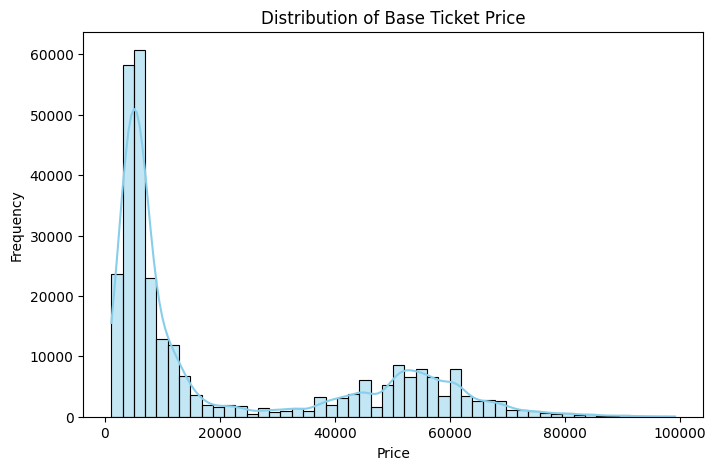

In [94]:
plt.figure(figsize=(8, 5))
sns.histplot(df['PRICE'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Base Ticket Price")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

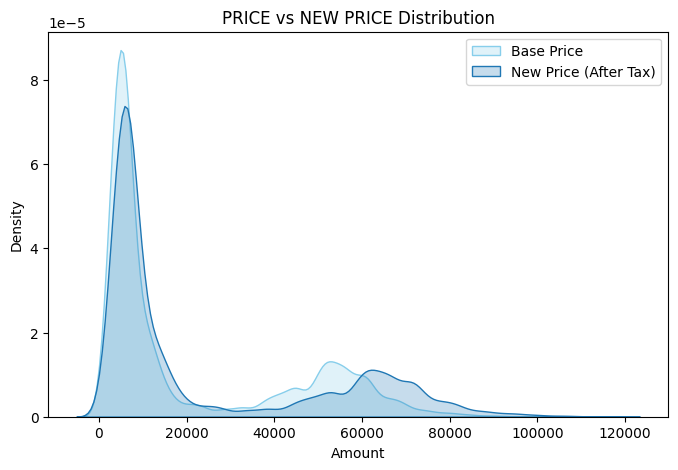

In [95]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df['PRICE'], label='Base Price', fill=True, color='skyblue')
sns.kdeplot(df['NEW PRICE'], label='New Price (After Tax)', fill=True)
plt.title("PRICE vs NEW PRICE Distribution")
plt.xlabel("Amount")
plt.legend()
plt.show()

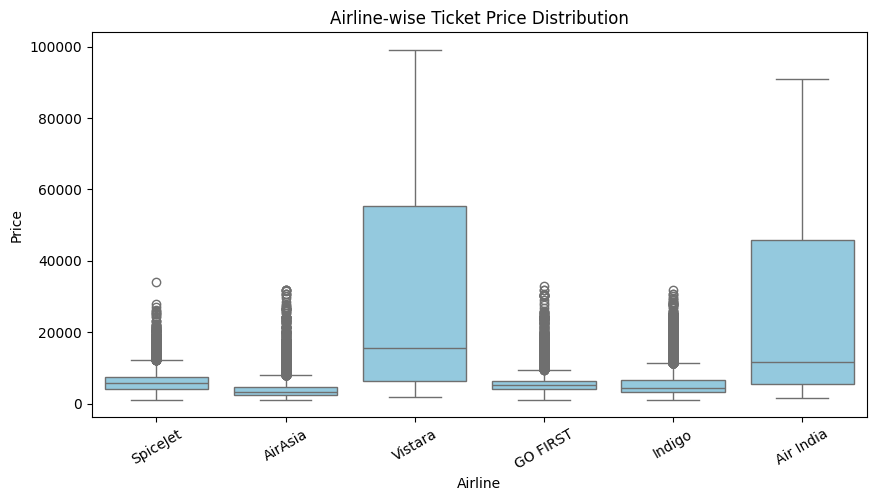

In [96]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='AIRLINE', y='PRICE', data=df, color='skyblue')
plt.title("Airline-wise Ticket Price Distribution")
plt.xlabel("Airline")
plt.ylabel("Price")
plt.xticks(rotation=30)
plt.show()

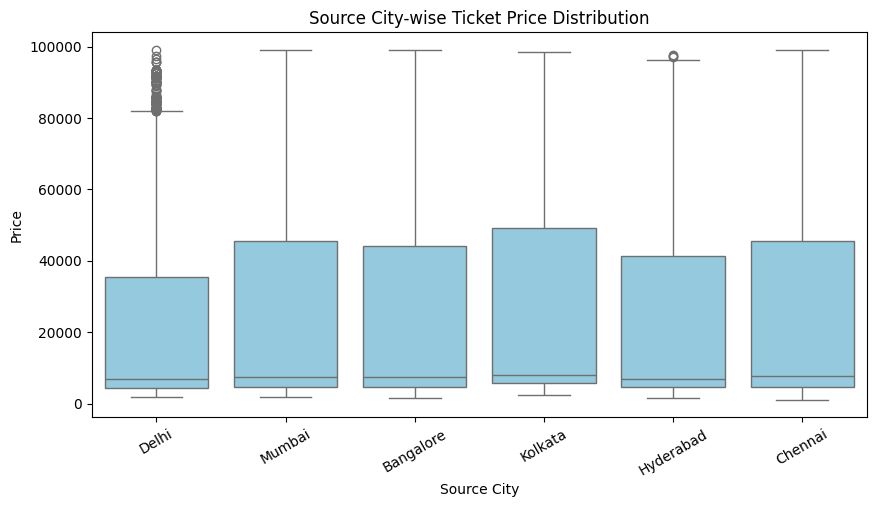

In [97]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='SOURCE CITY', y='PRICE', data=df, color='skyblue')
plt.title("Source City-wise Ticket Price Distribution")
plt.xlabel("Source City")
plt.ylabel("Price")
plt.xticks(rotation=30)
plt.show()

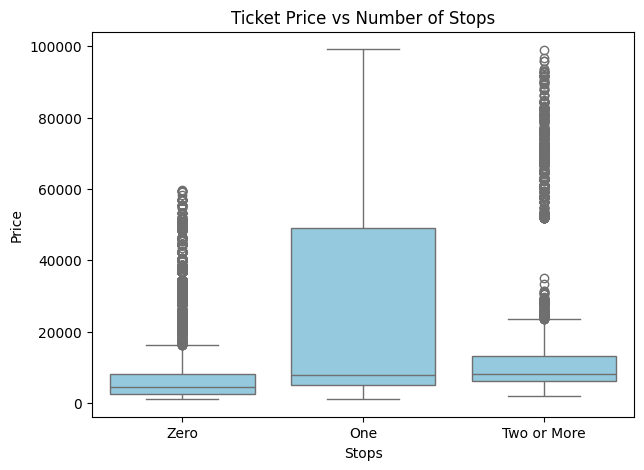

In [98]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='STOPS', y='PRICE', data=df, color='skyblue')
plt.title("Ticket Price vs Number of Stops")
plt.xlabel("Stops")
plt.ylabel("Price")
plt.show()

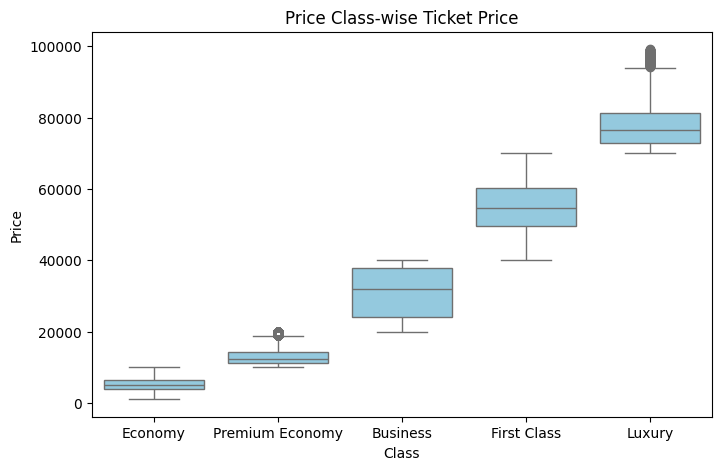

In [99]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='PRICE CLASS', y='PRICE', data=df, color='skyblue')
plt.title("Price Class-wise Ticket Price")
plt.xlabel("Class")
plt.ylabel("Price")
plt.show()

In [100]:
df.columns

Index(['AIRLINE', 'SOURCE CITY', 'STOPS', 'DESTINATION CITY', 'PRICE CLASS',
       'BOOKING YEAR', 'BOOKING MONTH', 'BOOKING DAY', 'DAYS LEFT',
       'FLIGHT YEAR', 'FLIGHT MONTH', 'FLIGHT DAY', 'DEPARTURE TIME',
       'DURATION', 'ARRIVAL TIME', 'PRICE', 'CGST', 'SGST', 'NEW PRICE'],
      dtype='object')

In [101]:
X = df.drop(columns=['PRICE', 'CGST', 'SGST', 'NEW PRICE'])

y = df['PRICE']

In [102]:
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

In [103]:
print("Categorical:", categorical_features)
print("Numerical:", numerical_features)
print("Total features:", len(categorical_features) + len(numerical_features))

Categorical: ['AIRLINE', 'SOURCE CITY', 'STOPS', 'DESTINATION CITY', 'PRICE CLASS', 'DEPARTURE TIME', 'ARRIVAL TIME']
Numerical: ['BOOKING YEAR', 'BOOKING MONTH', 'BOOKING DAY', 'DAYS LEFT', 'FLIGHT YEAR', 'FLIGHT MONTH', 'FLIGHT DAY', 'DURATION']
Total features: 15


In [104]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

In [105]:
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_features),('cat', categorical_transformer, categorical_features)])

In [119]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', RandomForestRegressor(n_estimators=70, max_depth=15,max_features='sqrt', random_state=42, n_jobs=-1))])

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [121]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['BOOKING YEAR',
                                                   'BOOKING MONTH',
                                                   'BOOKING DAY', 'DAYS LEFT',
                                                   'FLIGHT YEAR',
                                                   'FLIGHT MONTH', 'FLIGHT DAY',
                                                   'DURATION']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['AIRLINE', 'SOURCE CITY',
                                                   'STOPS', 'DESTINATION CITY',
                                                   'PRICE CLASS',
                                                   'DEPARTURE TIME',
                                                   'ARRIVAL TIME'])])),
                ('model',
                 RandomForestRegressor(max_depth=15, max_features='sqrt',
                                       n_estimators=70, n_jobs=-1,
                                       random_state=42))])

In [122]:
y_pred = pipeline.predict(X_test)


print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

MAE: 1958.5686603547495
RMSE: 3117.4652987076074
R²: 0.9811306734025586


In [123]:
import joblib

joblib.dump(pipeline, "flight_price_model.pkl")

['flight_price_model.pkl']

In [124]:
joblib.dump(categorical_features, "categorical_features.pkl")

['categorical_features.pkl']

In [125]:
joblib.dump(numerical_features, "numeric_features.pkl")

['numeric_features.pkl']